<a href="https://colab.research.google.com/github/fabiomontello/Video_Frame_Interpolation-A_NN_Project/blob/master/Exam_Neural_Networks_Fabio_Montello_1834411.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications (2019/2020)
## Final exam (template)

* **Student(s)**: Fabio Montello (1834411).
* **Reference paper / topic**: Simon Niklaus and Long Mai and Feng Liu, 2017. Video Frame Interpolation via Adaptive Separable Convolution, IEEE International Conference on Computer Vision. [Link to the paper](http://openaccess.thecvf.com/content_cvpr_2017/papers/Niklaus_Video_Frame_Interpolation_CVPR_2017_paper.pdf).



## Part 1: Report

This paper presents a video frame interpolation method that combines in a single fully convolutional neural network model the two basic steps of frame interpolation: model motion estimation and pixel synthesis.The neural network model considers pixel synthesis for the interpolated frame as local convolution over two input frames. The convolution kernel captures both the local motion between the input frames and the coefficients for pixel synthesis. The formulation of video interpolation as a single convolution process allows the handle of challenges like occlusion, blur, and abrupt brightness change and enables high-quality video frame interpolation.
Specifically, for a pixel (x, y) in the interpolated frame, this deep neural network takes two receptive field patches R1 and R2 centered at that pixel as input and estimates a convolution kernel K. This convolution kernel is used to convolve with the input patches P1 and P2 to synthesize the output pixel, as illustrated in Figure 1.

<div style="text-align:center; margin: 0 auto; width:100%;">
  <img src="https://raw.githubusercontent.com/fabiomontello/Video_Frame_Interpolation-A_NN_Project/master/imgs/figure1.png" alt="Figure 1" width="600"/>
</div>

Compared to other techniques of frame interpolation, this methos  to have some advantages:

1. It is able to make proper trade-offs among competing constraints and can provide a robust interpolation approach.
2. Can be directly trained end to end using widely available video data, without any difficult-to-obtain ground truth data like optical flow.
3. This method is able to generate high-quality frame interpolation results for challenging videos such as those with occlusion, blurring artifacts, and abrupt brightness change, as demonstrated in the paper and reproduced in this project.

### Network architecture
The neural network model presented in the paper and reproduced in this project consists of several convolutional layers as well as down-convolutions as alternatives to max-pooling layers. The architecture of the network is the following:
<div style="text-align:center">
  <img src="https://raw.githubusercontent.com/fabiomontello/Video_Frame_Interpolation-A_NN_Project/master/imgs/figure2.png" alt="Figure 2" width="400"/>
</div>
The model takes in input two images (each with the three channels), making the input tensor of shape (79, 79, 6). The output of the model is a kernel of shape (82,41) which needs to be convolved with a patch (crop) of the input images concatenated in order to produce the output color. The patch shape is (82,41,3) and convolved with the kernel will return respectively the value in each channel. A larger receptive field than the patch is used in order to better handle the aperture problem in motion estimation. Rectified Linear Units is used as activation functions, meanwhile and Batch Normalization is used for regularization. A critical constraint is that the coefficients of the output convolution kernel should be non-negative and sum up to one. Therefore, we connect the final convolutional layer to a spatial softmax layer to output the convolution kernel.

### Loss Function
The loss function presented by the paper is the following:
$$ E_c + \lambda * E_g $$
where $E_c$ is the color loss and $E_g$ is the gradient loss. 
The color loss is defined as following:
$$E_c = \sum_i ||[P_{i,1} P_{i,2}] * K_i - \widetilde{C}_i||_1$$
where $[P_{i,1} P_{i,2}]$ is the concatenation of the two crop patches of dimension (42,42) centered at the desired pixel, $K_i$ is the kernel output of our model and $\widetilde{C}_i$ is the true color we want to predict.
The gradient loss $E_g$ is instead defined as:
$$E_g = \sum_i \sum_{k=1}^8 ||[G_{i,1}^k G_{i,2}^k] * K_i - \widetilde{G}_i^k||_1$$

where $k$ denotes one of the eight versions of the gradient computed into the 8 immediate pixels around our desired target. $[G_{i,1}^k G_{i,2}^k$ is the gradient for the two crop patches dimensions, first computed and then concatenated. Then is convolved with the kernel predicted and subtracted to the actual gradient. The sum of all the gradients will define our loss.
As said previously, the two gradients gets combined in order to compute the loss. A good value of lamda according to the paper is 1. Reimplementing this solution, I found that 1 is a very high value, and a lambda equal to 0.001 works better on my training, giving visual results which are more consistent. This could be due to a misinterpretation of how to compute the gradient or the fact that the dataset had images with a lower resolution than the original one.

### Training specs
According to what is described into the paper, in order to train the neural network, we initialize its parameters using the Xavier initialization approach. Since not specified, I decided to use Xavier uniform instead of the normal.
The optimizer algorithm used is AdaMax with $\beta_1 = 0.9$, $\beta_2 = 0.999$ and learning rate of 0.001. The mini-batch size used is of 128 samples.

### Training dataset
The dataset for this project was different than the one proposed from the paper. The paper proposed the download of 3000 publicly available videos from Flickr using keywords, such as “driving”, “dancing”, “surfing”, “riding”, and “skiing”. The setting of the API and the download of the videos has resulted to be quite time consuming, so instead I opted to search for an already built dataset that was containing movement inside the clips. The [Hollywood 2 Action](https://www.di.ens.fr/~laptev/actions/hollywood2/) dataset from the paper Actions in Context of Marza, Laptev and Schmid suited my case, since was collecting scenes from american movies with action in them, in order to challenge the network with non-trivial cases. The Hollywood 2 Action datasets contains 2517 short clips from which I extracted three sequential frames every second. Later for each frame in the triplet I extracted 25 patches of 150x150 pixels, all centered around a random pixel $(x,y)$. These patches (called crops in the code) organized in sequential folders and identifiead with the letters *a*, *b* and *c* consists in the dataset from which the model has been trained.
In order facilitate data augmentation, the patches are selected to be larger than the receptive-field patches required by the neural network, which is 79x79 pixels. Data augmentation is performed on the fly during training by randomly crop the receptive field, as well as flipping the horizontally and vertically. In addition the images temporal order is randomly swapped. This
forces the optical flow within the samples to be distributed
symmetrically so that the neural network is not biased towards a certain direction.


Paper link: http://openaccess.thecvf.com/content_cvpr_2017/papers/Niklaus_Video_Frame_Interpolation_CVPR_2017_paper.pdf

Dataset https://www.di.ens.fr/~laptev/actions/


## Part 2: External libraries

*datasetCreationUtils* is an extrenal library created by me in order to process the clips of the dataset first into triplets of frames and later in patches that will be used to train and test the model. The functions that are part of this library are:

* *extractFromVideos*: given a list, call the function to extract the frame for each video
* *extractFrames*: given a video, extracts a triplet of frame at interval of N frames (in our case, 25)
* *crop_image*: function to crop a square image of 150 x 150 around a given pixel
* *build_dataset*: function which takes every triplet of images in the dataset and extract 25 random patches of 150 x 150 around the same pixel. It stores them in a folder that will be then compressed and saves the files path in a pandas dataframe, which will be used later to load the data in tensorflow

In [0]:
%tensorflow_version 2.x #Set TF version two 2
!rm -rf mylibs #Remove any folder mylibs (if present, in case of reload)
!git clone https://github.com/fabiomontello/Video_Frame_Interpolation-A_NN_Project.git mylibs #Clone the github repository of the project

# Move the datasetCreationUtils.py to the main folder.
# This is a set of functions build in order to extract frames from videos and 
# patches from frames in case the dataset is not downloadable
!mv mylibs/datasetCreationUtils.py datasetCreationUtils.py 

# Attempt to download the copy of the datasets from google drive
# instead of rebuilding them each time 
!pip install gdown
!gdown https://drive.google.com/uc?id=1-7BI2oSuA1LkYtB34jQk4VlH1Mhu3h4y # crops.zip
!gdown https://drive.google.com/uc?id=1WYgmFZemO08TL81tyEOcALYljmjoUi6j # data.csv

import tensorflow as tf #TF is used in order to build NN models
import cv2 # OpenCV is a library used to open videos and images, 
           # in order to extract frames and patches to use as dataset
import os #Used to 
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import time

from tensorflow.keras import Model
from tensorflow.keras import layers, models, regularizers, initializers, losses, optimizers, metrics
from google.colab import drive
from pathlib import Path #Works for Python 3.4> 
# This library is used in order to verify if the existence of files

import datasetCreationUtils as dsutils # Custom library

MOUNT_DRIVE = True # If you don't want to save the model weight to drive, set this to false
if(MOUNT_DRIVE):
  drive.mount('/content/drive/')
  WK_PATH = 'drive/My Drive/nn_project/' #Add your working path here
else:
  WK_PATH = './'
# set the working path as /content/ if you don't use Google Drive
BATCH_SIZE = 128

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x #Set TF version two 2`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Cloning into 'mylibs'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 101 (delta 35), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (101/101), 586.67 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Downloading...
From: https://drive.google.com/uc?id=1-7BI2oSuA1LkYtB34jQk4VlH1Mhu3h4y
To: /content/crops.zip
4.40GB [01:26, 50.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WYgmFZemO08TL81tyEOcALYljmjoUi6j
To: /content/data.csv
13.9MB [00:00, 52.7MB/s]
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Part 3: Your code

In this part I'm going to illustrate my code, chunk by chunk. I will try to give a general idea of what each chunk does. In order to understand specific parts of how the algorithms works, please refer to the comments in the code.

 This block of code is going to check if a copy of the already prepared dataset has been correctly downloaded from a cloud copy on the Google Drive. Since this code needs to be executed just once, I saved a copy of the dataset on Google drive and attempt to download it, in order to save resources and time, avoiding to process the original dataset in order to extract sequential frames and crops every time. 
Specifically this part checks if the files *crops.zip* and *pictures.zip* are present in the working path. If they are, we proceed to extract them. If they are not, it means the download from google drive has failed, so we proceed to download the original dataset (or just the frames extracted if the dataset is available on drive) and recreate the crop dataset.

In [0]:
#check if we have the dataset created. If so, copy and unzip it, 
# otherwise create the dataset fron the source and store a copy
bash_dir = 'pictures.zip'
bash_save = 'crops.zip'

if not(Path('crops.zip').is_file() and Path('data.csv').is_file()):
  !gdown https://drive.google.com/uc?id=1LhWbPXAcMW_2491RpxO6f0EcBBqN6OmG # pictures.zip
  #Check if we have the datasource, otherwise we download it in order to create the dataset
  if not Path('pictures.zip').is_file():
    !wget ftp://ftp.irisa.fr/local/vistas/actions/Hollywood2-actions.tar.gz # 17GB!
    !tar -xvzf Hollywood2-actions.tar.gz # Unzip the .gz file
    !rm Hollywood2-actions.tar.gz # Remove the folder that are not needed and the
    !rm -rf Hollywood2/ClipSets/  # archive in order to save space
    !rm -rf Hollywood2/ShotBounds/
    # Extract triplets of frames from the list of videos
    dsutils.extractFromVideos(os.listdir("/content/Hollywood2/AVIClips/"), '/content/'+WK_PATH+'images/')
    tmp = Path('images/')
    !zip -r pictures.zip 'images/' # zip the file (in order to save it and avoid)
                                   # repeating this process all the time
  else:
    !unzip -q pictures.zip
  #Create the crops dataset
  data = dsutils.build_dataset()  # from the triplets of frames, extract random crops of 150x150
  data.to_csv('data.csv', index=False) # save the dataset containing the names of the images
  !zip -r crops.zip ./crops/
else: #if we have it, we copy it
  !unzip -q /content/crops.zip # unzip the file
  data = pd.read_csv('data.csv') # read the dataset
  data = data.sample(frac=1).reset_index(drop=True) # shuffle the images, so sequential scenes appears randomly

Let's have a look at the shape of the dataset:

In [0]:
data.shape # shape of the dataset

(201375, 5)

and an example of how it is composed:

In [0]:
data.head(4) 

frameA                frameB                frameC    x    y
0  ./crops/191727/a.jpg  ./crops/191727/b.jpg  ./crops/191727/c.jpg  125   85
1  ./crops/172184/a.jpg  ./crops/172184/b.jpg  ./crops/172184/c.jpg  342   87
2  ./crops/104128/a.jpg  ./crops/104128/b.jpg  ./crops/104128/c.jpg  217  131
3  ./crops/177948/a.jpg  ./crops/177948/b.jpg  ./crops/177948/c.jpg  452   87

Let's print some triplets of images in order to see if everything done so far is correct. These are three crops of size 150x150 centered on the same pixel of three sequential frames:

<Figure size 432x288 with 0 Axes>

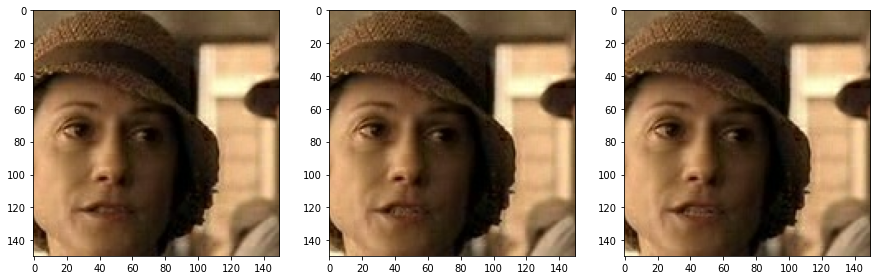

In [0]:
plt.figure(1)
plt.figure(figsize=(15,8))

img = tf.io.read_file('./crops/2885/a.jpg')
img = tf.io.decode_image(img, channels=3)
plt.subplot(131)
plt.imshow(img[:,:,::-1]) 
# During the processing, the images have been saved in BGR instead of RGB, it is  
# possible to fix that by displaying the channels inverted.

img = tf.io.read_file('./crops/2885/b.jpg')
img = tf.io.decode_image(img, channels=3)
plt.subplot(132)
plt.imshow(img[:,:,::-1])

img = tf.io.read_file('./crops/2885/c.jpg')
img = tf.io.decode_image(img, channels=3)
plt.subplot(133)
plt.imshow(img[:,:,::-1])

plt.show()

<Figure size 432x288 with 0 Axes>

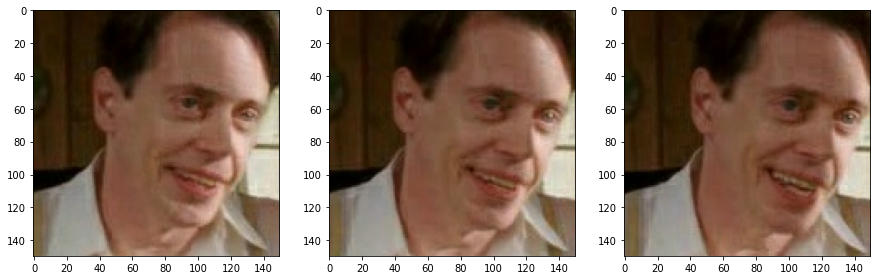

In [0]:
plt.figure(1)
plt.figure(figsize=(15,8))

img = tf.io.read_file('./crops/46785/a.jpg')
img = tf.io.decode_image(img, channels=3)
plt.subplot(131)
plt.imshow(img[:,:,::-1])

img = tf.io.read_file('./crops/46785/b.jpg')
img = tf.io.decode_image(img, channels=3)
plt.subplot(132)
plt.imshow(img[:,:,::-1])

img = tf.io.read_file('./crops/46785/c.jpg')
img = tf.io.decode_image(img, channels=3)
plt.subplot(133)
plt.imshow(img[:,:,::-1])

plt.show()

Before using the dataset to train the network, I defined two functions in order to perform data pre-processing and data augmentation on-the-go.   

The data preprocess function takes care of reading the images, extracting random patches from the triplet of images (all centered on the same pixel) and padding if necessary. This function returns as output a concatenation of the patches A and C (of shape (79,79,2)) which is the input of our network and the patch B which contains the ground truth pixel in the center of the image.

The data augmentation function performs randomly different kinds of augmentations, following what has been implemented in the paper: random switch of the order of patches A and C and randomly flipping horizontally and vertically of the concatenation of the patches.

The output is a test performed on the first image in the dataset, in order to verify that everything works as desired. The output is the center pixel of the two images and a plot of the image and of a single channel of the image.

tf.Tensor([0.28627452 0.19215687 0.11372549], shape=(3,), dtype=float32)
tf.Tensor([0.25882354 0.16470589 0.08627451], shape=(3,), dtype=float32)
(1, 79, 79, 6)


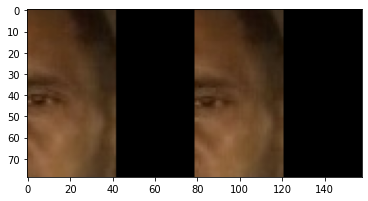

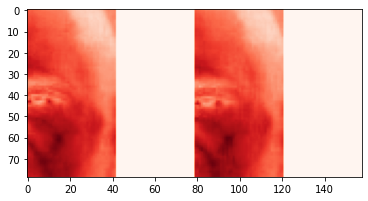

In [0]:
# prepare the dataset to be process by tensorflow
dataset = tf.data.Dataset.from_tensor_slices(dict(data.iloc[:,:3]))

# IMAGE PREPROCESSING FUNCTION
def img_preprocess(pt):
  # selection of a random pixel in the image
  x = random.randint(0, 150)
  y = random.randint(0, 150)

  # read of the first image, with normalization of the pixels between 0 and 1
  imgA = tf.io.read_file(pt['frameA'])
  imgA = tf.io.decode_image(imgA, channels=3)
  imgA = tf.cast(imgA, tf.float32)/255

  # read of the second image
  imgB = tf.io.read_file(pt['frameB'])
  imgB = tf.io.decode_image(imgB, channels=3)
  imgB = tf.cast(imgB, tf.float32)/255

  # read of the third image
  imgC = tf.io.read_file(pt['frameC'])
  imgC = tf.io.decode_image(imgC, channels=3)
  imgC = tf.cast(imgC, tf.float32)/255

  # if necessary, perform padding arounf the image
  if(x < 40 or x > 110 or y < 40 or y > 110):
    padx_low = padx_hi = pady_low = pady_hi = 39
    
    x = x + padx_low
    y = y + pady_low

    paddings = tf.constant([[padx_low, padx_hi], [pady_low, pady_hi], [0, 0]])

    imgA = tf.pad(imgA, paddings)
    imgB = tf.pad(imgB, paddings)
    imgC = tf.pad(imgC, paddings)

  # Crop the images around the randomly selected pixel
  # (also invert the channels to be RGB instead of BGR)
  imgA = imgA[(x-39):(x+40),(y-39):(y+40), ::-1]
  imgB = imgB[(x-39):(x+40),(y-39):(y+40), ::-1]
  imgC = imgC[(x-39):(x+40),(y-39):(y+40), ::-1]

  # concatenates the crops A and C
  patch = tf.concat([imgA, imgC], 2)

  # return the concatenation and the image containing the GT pixel to predict
  return patch, imgB

# IMAGE AUGMENTATION FUNCTION
def img_augment(patch, imgB):

  # with 0.5 probability, perform swap between image A and image C
  if(np.random.rand() > .5):
    patch =  tf.concat([patch[:,:,3:6], patch[:,:,0:3]],2)

  # with 0.5 probability, flip all the images horizontally
  if(np.random.rand() > .5):
    patch =  tf.concat([ tf.image.flip_left_right(patch[:,:,0:3]), tf.image.flip_left_right(patch[:,:,3:6])],2)
    imgB = tf.image.flip_left_right(imgB)

  # with 0.5 probability, flip all the images vertically
  if(np.random.rand() > .5):
    patch =  tf.concat([ tf.image.flip_up_down(patch[:,:,0:3]), tf.image.flip_up_down(patch[:,:,3:6])],2)
    imgB = tf.image.flip_up_down(imgB)

  return patch, imgB

# We can have a look at one example, printing the  the input centered pixels, 
# the concatenated crops (in sequence) and a single channel of the crops
for x, y in dataset.map(img_preprocess).map(img_augment).batch(1).take(1): 

  print(x[0,40,40,0:3])
  print(x[0,40,40,3:6])
  print(x.shape)
  plt.imshow(tf.concat([x[0,:,:,0:3], x[0,:,:,3:6]], 1))
  plt.show()
  plt.imshow(tf.concat([x[0,:,:,0], x[0,:,:,3]], 1), cmap='Reds')
  plt.show()

It is possible now to proceed by splitting the train, the validation and the test sets, performing the data preprocessing in all of them and the data augmentation only on the train dataset. We took 75% of the total images for train and evaluation, and the rest for test.

In [0]:
# Split the dataset
n = int(len(data) * 0.25)
m = int(n*0.25)
test_dataset = dataset.take(n)
train_dataset = dataset.skip(n)
eval_dataset = train_dataset.take(m)
train_dataset = train_dataset.skip(m)

# Perform preprocessing on every set and augmentation on the test set
train_dataset = train_dataset.map(img_preprocess).map(img_augment).shuffle(1000).batch(BATCH_SIZE)
test_dataset = test_dataset.map(img_preprocess).batch(BATCH_SIZE)
eval_dataset = eval_dataset.map(img_preprocess).batch(BATCH_SIZE)

Next I define a function that create our Convolutional model:

In [0]:
def create_model(verbose=True):
  model = models.Sequential()

  # input + 1st layer
  input1 = layers.Input(shape=(79, 79, 6))
  model.add(input1)
  model.add(layers.Conv2D(32, kernel_size = 7, strides=(1, 1), activation='relu', kernel_initializer='glorot_uniform'))
  model.add(layers.BatchNormalization())
  #2nd layer
  model.add(layers.Conv2D(32, kernel_size = 2, strides=(2, 2), activation='relu', kernel_initializer='glorot_uniform'))
  #3rd layer
  model.add(layers.Conv2D(64, kernel_size = 5, strides=(1, 1), activation='relu', kernel_initializer='glorot_uniform'))
  model.add(layers.BatchNormalization())
  #4th layer
  model.add(layers.Conv2D(64, kernel_size = 2, strides=(2, 2), activation='relu', kernel_initializer='glorot_uniform'))
  #5th layer
  model.add(layers.Conv2D(128, kernel_size = 5, strides=(1, 1), activation='relu', kernel_initializer='glorot_uniform'))
  model.add(layers.BatchNormalization())
  #6th layer
  model.add(layers.Conv2D(128, kernel_size = 2, strides=(2, 2), activation='relu', kernel_initializer='glorot_uniform'))
  #7th layer
  model.add(layers.Conv2D(256, kernel_size = 3, strides=(1, 1), activation='relu', kernel_initializer='glorot_uniform'))
  model.add(layers.BatchNormalization())
  #8th layer
  model.add(layers.Conv2D(2048, kernel_size = 4, strides=(1, 1), activation='relu', kernel_initializer='glorot_uniform'))
  model.add(layers.Conv2D(3362, kernel_size = 1, strides=(1, 1)))
  #9th layer
  model.add(layers.Softmax())
  # #10th layer
  model.add(layers.Reshape((41,82,1)))

  # if the user wants, we display a summary of the model
  if(verbose):
    model.summary()

  return model


model = create_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 73, 73, 32)        9440      
_________________________________________________________________
batch_normalization_4 (Batch (None, 73, 73, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 36, 36, 32)        4128      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        16448     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 128)      

We want to load also tensorboard in order to keep the training under observation. This can be useful since the time of training for each epoch is in between 5 and 10 minutes.

In [0]:
bash_tf = WK_PATH + 'logs/gradient_tape'
%load_ext tensorboard
%tensorboard --logdir "$bash_tf"

<IPython.core.display.Javascript object>

Next we want to define the custom loss according to what defined by the theory (see above). The loss is composed by a color loss, which is obtained by computing the absolute mean error between the pixel predicted and the ground truth pixel, and a gradient loss, which is obtained as a sum of the mean absolute errors computed for 8 gradient directions around the desired pixel, compared to the ground truth gradients.

In [0]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Instantiate MAE loss function, will be used inside the custom loss function
loss_fn = tf.keras.losses.MeanAbsoluteError()

# Instantiate the accuracy and loss metrics.
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.Accuracy('train_accuracy')

# Custom los
def custom_loss(input, model, output, train=True):
  # Lambda value which balances color loss and gradient loss
  lamb = 0.0001

  # Batch size (takes into account the dimension of the last batch, which is smaller)
  batch_size = input.shape[0]

  # Target pixel to predict
  target = output[:,40,40,:]

  # Extract input patches to be convolved with the kernel
  patch1 = input[:, 19:(19+41), 19:(19+41), 0:3] # First patch
  patch2 = input[:, 19:(19+41), 19:(19+41), 3:] # Second patch

  inp = tf.concat([patch1, patch2], axis=2) # Concatenation on the length

  # Get the kernel of the input patches
  prediction = model(input, training=train)

  # Flat the kernel, in order to compute the dot product with the patch
  prediction = tf.keras.backend.batch_flatten(prediction)

  #################### COLOR LOSS ##########################
  # Extract the single channels
  R = tf.keras.backend.batch_flatten(inp[:,:,:,0])
  G = tf.keras.backend.batch_flatten(inp[:,:,:,1])
  B = tf.keras.backend.batch_flatten(inp[:,:,:,2])

  # Execute the dot product of the kernel in each channel
  R_pred = tf.keras.backend.batch_dot(R, prediction)
  G_pred = tf.keras.backend.batch_dot(G, prediction)
  B_pred = tf.keras.backend.batch_dot(B, prediction)

  # Compose the predicted pixel as RGB
  all_pred = tf.concat([R_pred, G_pred, B_pred], axis = 1)

  # Compute the color loss with the target pixel
  color_loss = loss_fn(all_pred, target)

  #################### GRADIENT LOSS ##########################
  # Take the image to compute the gradient loss
  out_gradient = tf.image.resize_with_crop_or_pad(output, 41, 41)
  # Take the ground truth image
  out_right = tf.image.resize_with_crop_or_pad(output, 39, 39)
     
  grad_coll = []

  for i in list([-1,0,1]): # For each pixel on the left or right side
     for j in list([-1,0,1]): # For each pixel on top or bottom
       if not(i==0 and j== 0): # If it is not the central pixel
        # Compute the ground truth gradient of the image
        grad_truth = tf.subtract(out_right, out_gradient[:, (1 +i):(40+i), (1 +j):(40+j), 0:3])
        # Mean over the 3 channels
        grad_truth = tf.reduce_mean(tf.reshape(grad_truth, [batch_size,-1,3]),1)

        # Get the gradient image for the current patches
        sub1 = tf.subtract(input[:, 19:(19+41), 19:(19+41), 0:3], input[:, (19+i):(19+41+i), (19+j):(19+41+j), 0:3])
        sub2 = tf.subtract(input[:, 19:(19+41), 19:(19+41), 3:], input[:, (19+i):(19+41+i), (19+j):(19+41+j), 3:])
        inp = tf.concat([sub1, sub2], axis=2)

        # Get the gradient value for RGB, and concatenate them
        R_grad = tf.keras.backend.batch_dot(R, tf.keras.backend.batch_flatten(inp[:,:,:,0]))
        G_grad = tf.keras.backend.batch_dot(G, tf.keras.backend.batch_flatten(inp[:,:,:,1]))
        B_grad = tf.keras.backend.batch_dot(B, tf.keras.backend.batch_flatten(inp[:,:,:,2]))
        grad_pred = tf.concat([R_pred, G_pred, B_pred], axis = 1)

        #Compute the gradient loss on that specific direction
        grad_coll.append(loss_fn(grad_pred,grad_truth))

  # Sum of the gradient losses in all possible directions
  grad_loss = tf.reduce_sum(tf.stack(grad_coll))

  # Composition of the final custom loss
  loss = color_loss + lamb * grad_loss
  
  return loss, all_pred, target

Then it is possible to define the functions to execute the train and evaluate the validation/test sets, in order to train our model and evaluate the performance:

In [0]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define loss and accuracy metrics for the test and evaluation set
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.Accuracy('test_accuracy')

loss_history = []
train_acc_hist = []
val_acc_hist = []

C
def test(model, optimizer,loss_fn, acc, dataset, t = None, epoch = None):
    # save for tensorboard only if it is evaluation
    if(t != None and epoch != None):
      test_log_dir = WK_PATH+'logs/gradient_tape/'+t +'test/' + epoch
      test_summary_writer = tf.summary.create_file_writer(test_log_dir)
    test_loss.reset_states()
    test_accuracy.reset_states()

    # For each value in the dataset passed
    for step, (input, target) in enumerate(dataset):
      # get the custom loss of the prediction
      loss_value, all_pred, tg = custom_loss(input, model, target, train=False)
      
      # compute loss and accuracy metrics
      test_loss(loss_value)
      test_accuracy(all_pred, tg)

      # Save only if it is validation set
      if(t != None and epoch != None):
        with test_summary_writer.as_default():
          tf.summary.scalar('loss', test_loss.result(), step=step)
          tf.summary.scalar('accuracy', test_accuracy.result(), step=step)
    return test_accuracy.result()

# Function to execute the train 
def train(model, optimizer,loss_fn, acc, train_dataset):
  epochs = 10
  
  # For each of the 10 epochs
  for epoch in range(epochs):

    # Prepare to save in tensorboard with an unique ID
    t = current_time
    print('Start of epoch %d' % (epoch,))
    train_log_dir = WK_PATH+'logs/gradient_tape/' + t +'/epoch'+ str(epoch) + '/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    train_loss.reset_states()
    train_accuracy.reset_states()

    # For each batch in the train dataset
    for step, (input, target) in enumerate(train_dataset):

      with tf.GradientTape() as tape:
        # Compute the loss value for this minibatch.
        loss_value, all_pred, tg = custom_loss(input, model, target)

      # Use the gradient tape to automatically retrieve
      # the gradients of the trainable variables with respect to the loss.
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Run one step of gradient descent by updating
      # the value of the variables to minimize the loss.
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      
      # compute the loss metrics
      train_loss(loss_value)
      loss_history.append(loss_value.numpy())
      train_accuracy(all_pred, tg)
      with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=step)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=step)
    
    train_acc_hist.append(train_accuracy.result())

    # At the end of the epoch, evaluate the validation set
    val_acc_hist.append(test(model, optimizer,loss_fn, acc, eval_dataset, t, str(epoch)))
        
train(model, optimizer,loss_fn, acc, train_dataset)

Start of epoch 0
Start of epoch 1
Start of epoch 2
Start of epoch 3
Start of epoch 4
Start of epoch 5
Start of epoch 6
Start of epoch 7
Start of epoch 8
Start of epoch 9


We can see what is the accuracy computed on the test set:

In [0]:
print('The accuracy in the test set is: ', test(model, optimizer,loss_fn, acc, eval_dataset).numpy())

The accuracy in the test set is:  0.117600314


In [0]:
t = current_time
# Save the model after training
model.save_weights(WK_PATH+'saved_model/original_paper'+t)
print(t)

20200422-120458


## Part 4 - Experimental evaluation

We show in the following part the results in term of metrics during the training epochs:

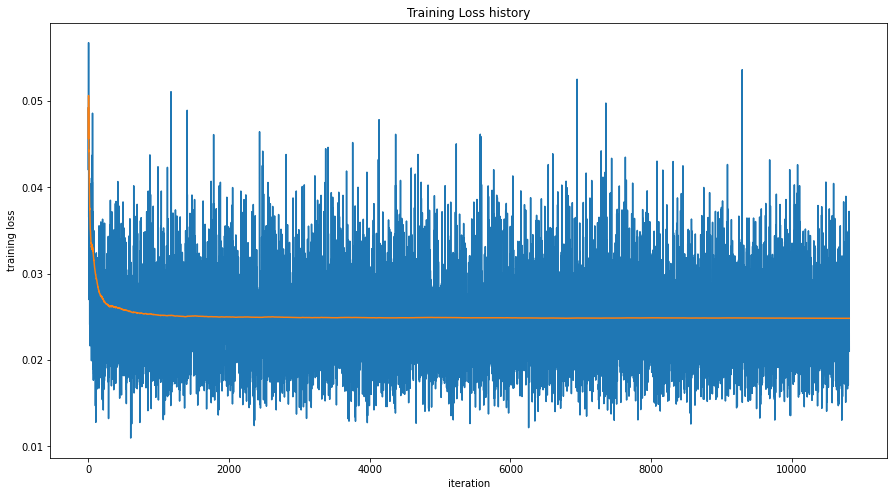

In [0]:
running_mean = []
n_var = 0
for i in range(len(loss_history)):
  running_mean.append(np.mean(loss_history[:i+1]))

plt.figure(1,figsize=(15,8))
plt.plot(loss_history, label = 'loss value')
plt.plot(running_mean, label='running loss')
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

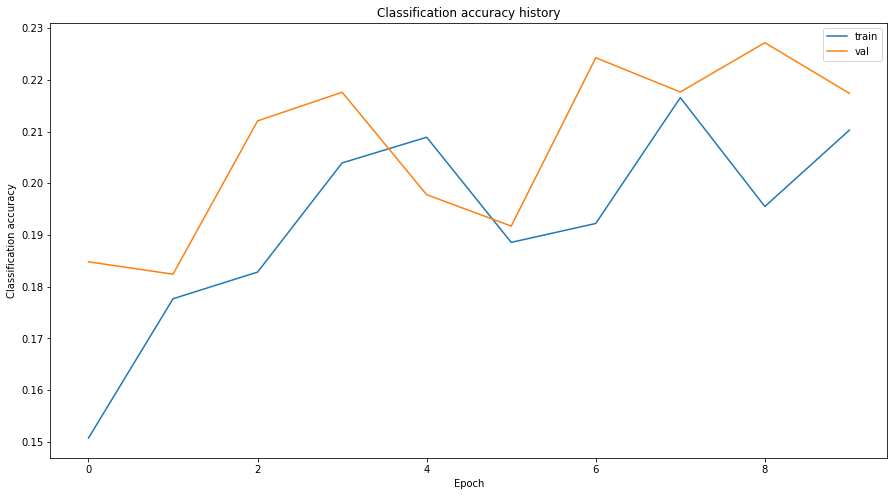

In [0]:
plt.figure(2,figsize=(15,8))
plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [0]:
model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper'+t)

We can also have a look at an example of the output of a kernel. In this case is the predicted kernel of the sample image printed above, where we tested the data_preprocessing and data_augmentation functons.

AxesImage(54,36;334.8x217.44)


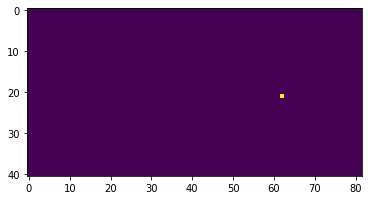

In [0]:
x.shape
print(plt.imshow(model(x, training=False)[0,:,:,0]))

Next a function has been created in order to obtain the output interpolated image given two input images:

In [0]:
def interpolated_image(imgA, imgB):
    # Normalize the images
    imgA = tf.cast(imgA, tf.float32)/255
    imgB = tf.cast(imgB, tf.float32)/255

    x = imgB.shape[0]
    y = imgB.shape[1]

    # pad the images with zeros
    padx_low = padx_hi = pady_low = pady_hi = 39
    paddings = tf.constant([[padx_low, padx_hi], [pady_low, pady_hi], [0, 0]])

    imgA = tf.pad(imgA, paddings)
    imgB = tf.pad(imgB, paddings)
    output = np.zeros(shape=(x,y, 3))

    for i in range(39, (39+x)): #For every row pixel
      patch1 = []
      patch2 = []
      for j in range(39, (39+y)): # for every column pixel
        # append in the list a new patch, in order to create a batch of patches for every row
        patch1.append(imgA[(i-39):(i+40),(j-39):(j+40), :])
        patch2.append(imgB[(i-39):(i+40),(j-39):(j+40), :])
        
      # predict the output pixels of the batch, from the kernels
      prediction = model(tf.reshape(tf.concat([patch1, patch2], 2), [y, 79,79,6]), training=False)
      prediction = tf.keras.backend.batch_flatten(prediction)

      inp = tf.concat([tf.image.resize_with_crop_or_pad(patch1, 41, 41), tf.image.resize_with_crop_or_pad(patch2, 41, 41)], axis=2)
      inp = tf.reshape(inp, [y, 82,41,3])

      R = tf.keras.backend.batch_flatten(inp[:,:,:,0])
      G = tf.keras.backend.batch_flatten(inp[:,:,:,1])
      B = tf.keras.backend.batch_flatten(inp[:,:,:,2])

      R_pred = tf.keras.backend.batch_dot(R, prediction)
      G_pred = tf.keras.backend.batch_dot(G, prediction)
      B_pred = tf.keras.backend.batch_dot(B, prediction)

      # Write the row of the image, with the predicted pixels
      for j in range(0, y):
        output[i-39,j] = [R_pred[j], G_pred[j], B_pred[j]]

    return output

It is then possible to proceed by importing the best model trained (the one trained above), with lambda 0.001 and 10 epochs of training: Then we can print the results. In the first row there are plotted the input images, and in the second the predicted image and the true interpolation.

In [0]:
model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200422-120458')

<Figure size 432x288 with 0 Axes>

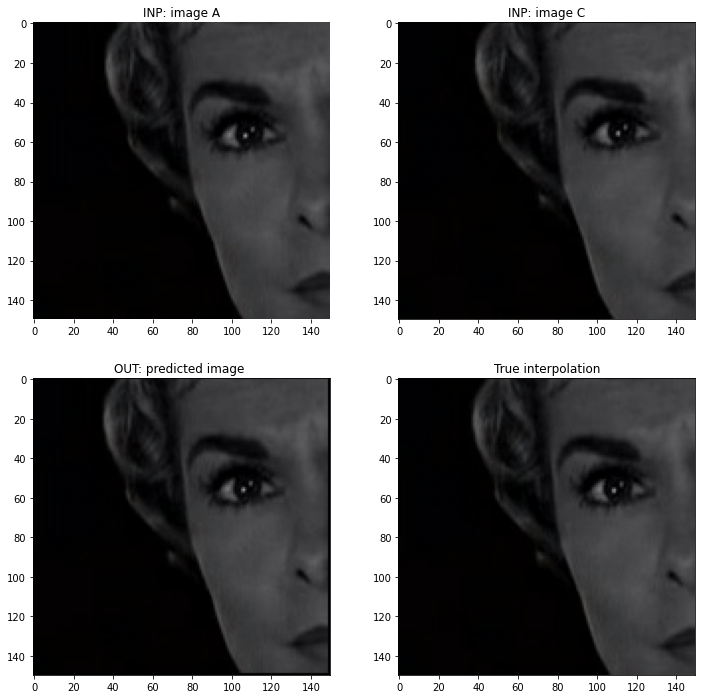

In [0]:
plt.figure(1)
plt.figure(figsize=(12,12))

img1 = tf.io.read_file('./crops/1883/a.jpg')
img1 = tf.io.decode_image(img1, channels=3)
img1 = np.array(img1)
plt.subplot(2,2,1, frameon=False).set_title('INP: image A')
plt.imshow(img1[:,:,::-1])

img2 = tf.io.read_file('./crops/1883/c.jpg')
img2 = tf.io.decode_image(img2, channels=3)
img2 = np.array(img2)
plt.subplot(2,2,2).set_title('INP: image C')
plt.imshow(img2[:,:,::-1])

img3 = interpolated_image(img1, img2)
plt.subplot(2,2,3).set_title('OUT: predicted image ')
plt.imshow(img3[:,:,::-1])


plt.show()

<Figure size 432x288 with 0 Axes>

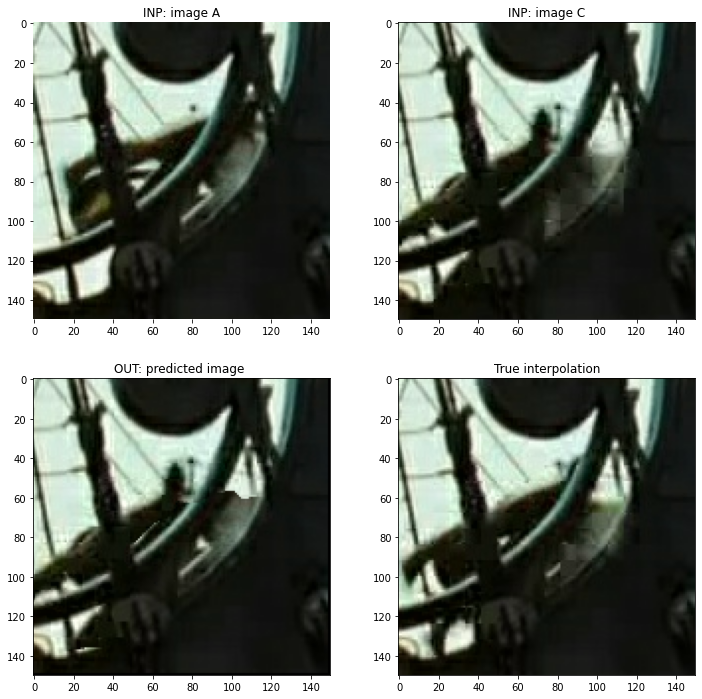

In [0]:
plt.figure(3)
plt.figure(figsize=(12,12))

img1 = tf.io.read_file('./crops/91650/a.jpg')
img1 = tf.io.decode_image(img1, channels=3)
img1 = np.array(img1)
plt.subplot(2,2,1, frameon=False).set_title('INP: image A')
plt.imshow(img1[:,:,::-1])

img2 = tf.io.read_file('./crops/91650/c.jpg')
img2 = tf.io.decode_image(img2, channels=3)
img2 = np.array(img2)
plt.subplot(2,2,2).set_title('INP: image C')
plt.imshow(img2[:,:,::-1])

img3 = interpolated_image(img1, img2)
plt.subplot(2,2,3).set_title('OUT: predicted image ')
plt.imshow(img3[:,:,::-1])

img4 = tf.io.read_file('./crops/91650/b.jpg')
img4 = tf.io.decode_image(img4, channels=3)
img4 = np.array(img4)
plt.subplot(2,2,4).set_title('True interpolation')
plt.imshow(img4[:,:,::-1])

plt.show()

<Figure size 432x288 with 0 Axes>

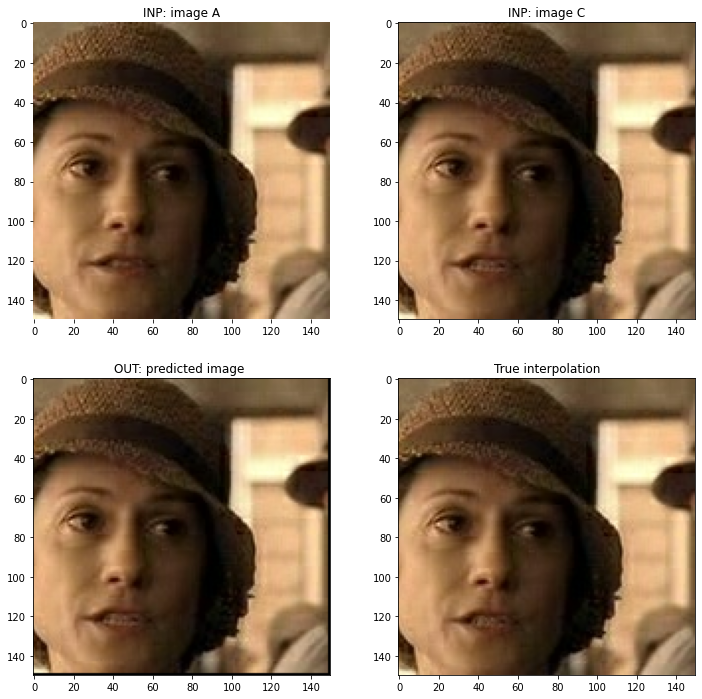

In [0]:
plt.figure(4)
plt.figure(figsize=(12,12))

img1 = tf.io.read_file('./crops/2885/a.jpg')
img1 = tf.io.decode_image(img1, channels=3)
img1 = np.array(img1)
plt.subplot(2,2,1, frameon=False).set_title('INP: image A')
plt.imshow(img1[:,:,::-1])

img2 = tf.io.read_file('./crops/2885/c.jpg')
img2 = tf.io.decode_image(img2, channels=3)
img2 = np.array(img2)
plt.subplot(2,2,2).set_title('INP: image C')
plt.imshow(img2[:,:,::-1])

img3 = interpolated_image(img1, img2)
plt.subplot(2,2,3).set_title('OUT: predicted image ')
plt.imshow(img3[:,:,::-1])

img4 = tf.io.read_file('./crops/2885/b.jpg')
img4 = tf.io.decode_image(img4, channels=3)
img4 = np.array(img4)
plt.subplot(2,2,4).set_title('True interpolation')
plt.imshow(img4[:,:,::-1])

plt.show()

Another thing interesting to observe is how the final image changes with different model trained on different lambda values. The sequence of images that follows show from top-left: original input frame A, original input frame C, various predictions with value of lambda between 1 and 0.0001, and the last image with lambda equals to zero, meaning having only the color loss and not the gradient loss:

<Figure size 432x288 with 0 Axes>

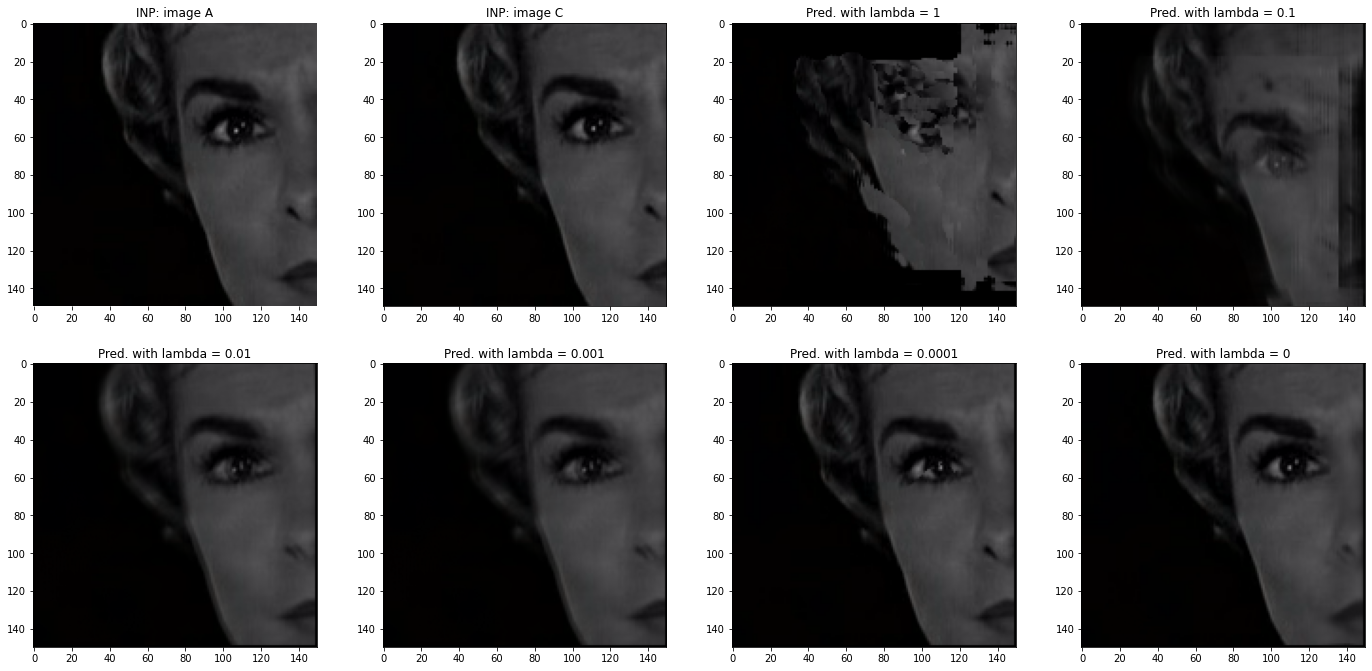

In [0]:
plt.figure(1)
plt.figure(figsize=(24,24))

img1 = tf.io.read_file('./crops/1883/a.jpg')
img1 = tf.io.decode_image(img1, channels=3)
img1 = np.array(img1)
plt.subplot(4,4,1, frameon=False).set_title('INP: image A')
plt.imshow(img1[:,:,::-1])

img2 = tf.io.read_file('./crops/1883/c.jpg')
img2 = tf.io.decode_image(img2, channels=3)
img2 = np.array(img2)
plt.subplot(4,4,2).set_title('INP: image C')
plt.imshow(img2[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200420-093841')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,3).set_title('Pred. with lambda = 1')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200421-141049')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,4).set_title('Pred. with lambda = 0.1')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200420-140907')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,5).set_title('Pred. with lambda = 0.01')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200420-151213')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,6).set_title('Pred. with lambda = 0.001')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200421-105550')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,7).set_title('Pred. with lambda = 0.0001')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200420-102652')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,8).set_title('Pred. with lambda = 0')
plt.imshow(img3[:,:,::-1])

plt.show()

<Figure size 432x288 with 0 Axes>

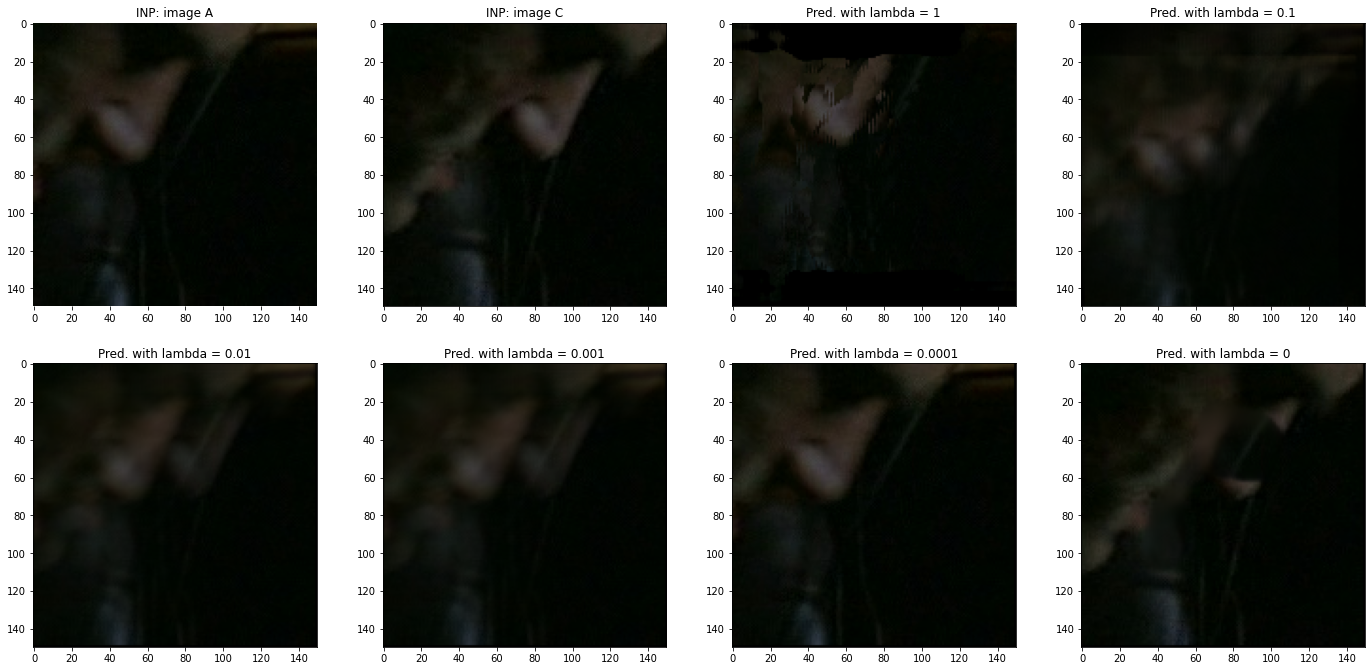

In [0]:
plt.figure(2)
plt.figure(figsize=(24,24))

img1 = tf.io.read_file('./crops/101933/a.jpg')
img1 = tf.io.decode_image(img1, channels=3)
img1 = np.array(img1)
plt.subplot(4,4,1, frameon=False).set_title('INP: image A')
plt.imshow(img1[:,:,::-1])

img2 = tf.io.read_file('./crops/101933/c.jpg')
img2 = tf.io.decode_image(img2, channels=3)
img2 = np.array(img2)
plt.subplot(4,4,2).set_title('INP: image C')
plt.imshow(img2[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200420-093841')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,3).set_title('Pred. with lambda = 1')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200421-141049')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,4).set_title('Pred. with lambda = 0.1')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200420-140907')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,5).set_title('Pred. with lambda = 0.01')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200420-151213')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,6).set_title('Pred. with lambda = 0.001')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200421-105550')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,7).set_title('Pred. with lambda = 0.0001')
plt.imshow(img3[:,:,::-1])

model = create_model(verbose=False)
model.load_weights(WK_PATH+'saved_model/original_paper20200420-102652')

img3 = interpolated_image(img1, img2)
plt.subplot(4,4,8).set_title('Pred. with lambda = 0')
plt.imshow(img3[:,:,::-1])

plt.show()

Since the final purpose of this project is to interpolate images to make slow motion videos, here is an example of a 24fps video converted to 48fps with the model trained above:

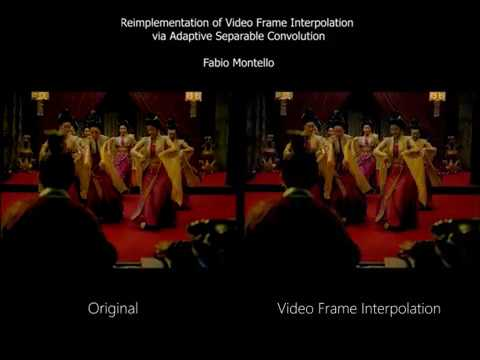

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('bURlDu8YjQk')

# Conclusions

The re-implementation of the network described from the paper seemed for the big part of it a success. The network is in fact able to create an image that is interpolation of two other, and the resulting kernels often shows that when an image is static, a pixel from either image A or image C from the input is chosen, meanwhile, when the image is dynamic, it tracks the movement and often average over the two images, with different weights. 
A part of the implementation that has been less successful is the gradient loss: this seems to ruin the actual result, by introducing huge artefacts and ghosts effect inside the predicted pixel and thus the output image. When the lambda value is very low, bringing very little contribute of the gradient loss to the total loss, the results are visibly better. This is in contrast with what was reported in the paper, where an optimal value of lambda was 1. 
The reasons for this problems may be differents: most probably is due to a bad interpetation of the meaning of gradient of an image, given a center pixel. In this project this has been understood as the difference between the central pixel and the 8 surrounding pixels. But since not clearly specified on the paper, this can be a misunderstanding of the actual gradient loss in the paper. 
Another fact that may be contributing to a worst result, is the different type of dataset. Although the Hollywood Movies dataset used in this project was a selection of actions scenes, it could be that the original dataset extracted from sport videos in Vimeo contains more movement, thus resulting in a better dataset for frame interpolation.